In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt 
import pickle 
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ttest_ind,  shapiro, mannwhitneyu, pearsonr
import seaborn as sb
import matplotlib.colors
from tqdm import tqdm 

N_episode = 300
FIGSIZE = (16,9)
colors10 = ['darkred', 'crimson', 'salmon', 'gold', 'lime', 
          'darkgreen', 'navy', 'royalblue', 'darkviolet', 'magenta'
         ]
colors = ['crimson','gold','darkgreen','royalblue', 'darkviolet']

LW = 5

In [2]:
def plot_performance(data, X=None, names=None, title="", ylabel="performance", 
                     minimum = -np.inf, maximum=np.inf, log=False, double=False, xlabel="learning episodes"):
    """
    data = [n_param, n_run, episode_length]
    """
    
    if names is None:
        names = [str(j) for j in range(len(data))]
    compute_X = (X is None)
    if len(data)<6:
        ncol = [1,1,2,2,3][len(data)-1] 
    else:
        ncol = len(data)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    handles = []
    for i in range(len(data)):
        if (double and i>=len(data)/2):
            linestyle = ":"
            color = colors[i%(len(data)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)]
        
        mean, std = np.mean(data[i], axis=0), np.std(data[i], axis=0)
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]

        for run in range(len(data[i])):
            plt.plot(X, data[i][run], color=color, lw=2, alpha=0.3, linestyle=linestyle)
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
       # ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
       # plt.plot(X, mean_p_std, color=color, alpha=0.2)
        #plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        #if (X[1]-X[0])!=(X[-1]-X[-2]):
        #    plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2,ncol=1,bbox_to_anchor=(1.01, 1.))
    plt.show()

In [68]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

def compute_test(data, coef=1, N=5):
    pairs = []
    for i in range(N-1):
        for j in range(i+1,N):
            pairs.append((i,j))
    res = [[] for _ in range(N)]
    cells = [[ '' for _ in range(N-1)] for _ in range(N-1)]
    for (param1,param2) in pairs:
        data1 = np.array(data[param1])
        data2 = np.array(data[param2])
        stat, p_t = ttest_ind(data1,data2)
        p_t = p_t*coef
        mean1 = np.median(data1)
        mean2 = np.median(data2)
        d = truncate(mean1/mean2, 2)
        if d=='0.00' or d=='-0.00':
            d = truncate( mean1/mean2, 3)
            if d=='0.000' or d=='-0.000':
                d = truncate( mean1/mean2, 4)
                
        if p_t < 0.001:
            res.append((param1, param2, '***'))
            cells[param1][N-1-param2] = d+'\n***'
        elif p_t < 0.01:
            res.append((param1, param2, '**'))
            cells[param1][N-1-param2] = d+'\n**'
        elif p_t < 0.05:
            res.append((param1, param2, '*'))
            cells[param1][N-1-param2] = d+'\n*'
        else:
            cells[param1][N-1-param2] = "ns"
    return res,cells

def plot_boxplot(data, names, ylabel="performance", ylim=None, title="", log=False):
    N = len(data)
    stat,cells = compute_test(data, 3*N*(N-1)/2, N)
    
    plt.subplots(figsize=(12,10))
    
    bplot = sb.boxplot(data=data)
    for i in range(N):
        bplot.artists[i].set_facecolor(colors[i])
    if np.size(data) < 1000:
        sb.swarmplot( data=data, color='black', edgecolor='black',size=7)
    
    rows = names[:N-1]
    columns = [names[i] for i in range(N-1,0,-1)]
    cell_text = cells
    cellColours = [['white' if N-1-i>j else 'lightgrey' for j in range(N-1)] for i in range(N-1) ]
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          cellColours= cellColours,
                          rowColours=colors[:N-1],
                          colColours=[ colors[i] for i in range(N-1,0,-1)],
                          colLabels=columns,
                          cellLoc = 'center',
                          bbox=(1.13,0.1,0.5,0.9))
    
    plt.xticks(range(N), names)
    if log:
        plt.yscale('log')
    if not ylim is None:
        plt.ylim(ylim)
    plt.ylabel(ylabel)
    plt.title(title)

def plot_model_training(subdirs, names):
    Train, Test = [], []
    for param in subdirs:
        trains, tests = [], []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            test = data['test_error']
            train = data['train_error']
            trains.append(np.mean(train,axis=1))
            tests.append(np.mean(test,axis=1))
            if min_length > len(test):
                min_length = len(test)
        tests = [ test[:min_length] for test in tests]
        trains = [ train[:min_length] for train in trains]
        Test.append(np.copy(tests))
        Train.append(np.copy(trains))
    Data = Train + Test
    Names = ["Training error "+x for x in names] + ["Testing error "+x for x in names]
    plot_performance(Data, names=Names, double=True, log=True, ylabel="Error", title="One Step Prediction Error")

In [4]:
def add_samples(samples, type="D", H=20):
    inputs, outputs = [], []
    if type == "D":
        acs = samples['acs']
        obs = samples['obs']
        indexes = []
        for i in range(len(acs)):
            T = len(obs[i])
            for t in range(len(acs[i])):
                if t < T-H:
                    my_index = len(inputs)
                    indexes.append(my_index)
                inputs.append(np.concatenate((obs[i][t][:28], obs[i][t][30:31], acs[i][t])))
                outputs.append(obs[i][t + 1]- obs[i][t])
        indexes = np.array(indexes)
    else:
        indexes = None
        ctrl = samples['controller']
        obs = samples['obs']
        for i in range(len(obs)):
            T = len(obs[i])
            for t in range(0, T-H):
                inputs.append(np.concatenate((obs[i][t][:28], obs[i][t][30:31], ctrl[i], [(t%25)/25])))
                outputs.append(obs[i][t + H][28:31]- obs[i][t][28:31])     
    return np.array(inputs), np.array(outputs), indexes

In [5]:
path = "exp/log/Saved/DC/"
file = "/logs.mat"

DC = [path + "2019-11-04--14:40:594233", path + "2019-11-04--13:56:157705", 'DC']

controller = [path + "2019-11-05--14:00:1136596", path +"2019-11-05--14:00:2291832", 'controller']

fallen = [path+"2019-11-07--15:16:0061293", path+'2019-11-07--15:15:3295399', 'fallen']

In [95]:
def plot(folders, j=0,H=20,data="train"):
    assert data in ["train", "eval"]
    [D,C,name] = folders
    with open("data/"+data+"_"+name+".pk", 'rb') as f:
        samples = pickle.load(f)
    obs = samples['obs']

    dataD = scipy.io.loadmat(D+"/logs.mat")
    Dpred = dataD[data+"_pred"][-1][0]
    dataC = scipy.io.loadmat(C+"/logs.mat")
    Cpred = dataC[data+"_pred"][-1][0]
    with open(D+"/indexes.pk", 'rb') as f:
        [[train_indexes,train_inv_indexes], [eval_indexes, eval_inv_indexes]] = pickle.load(f)
    if data == "train":
        inv_indexes = train_inv_indexes 
    else:
        inv_indexes = eval_inv_indexes
    [i,t] = inv_indexes[j]
    plt.subplots(figsize=(8,8))
    true_traj = np.array(obs[i])[t:t+H+1, 28:30]
    plt.plot(true_traj[:, 0], true_traj[:, 1], lw=5, color='darkgreen', label="True trajectory")
    plt.scatter(true_traj[0,0],true_traj[0,1], s=100, marker='o', color='darkgreen')
    plt.scatter(true_traj[-1,0], true_traj[-1,1], s=200, marker='+', color='darkgreen')
    
    plt.plot(Dpred[:, j, 0]+true_traj[0,0], Dpred[:, j, 1]+true_traj[0,1], lw=5, color="royalblue", label="Predicted trajectory")
    
    plt.scatter(Cpred[j,0]+true_traj[0,0], Cpred[j,1]+true_traj[0,1], marker='+', s=200, color='crimson', label="Predicted final position")
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend()

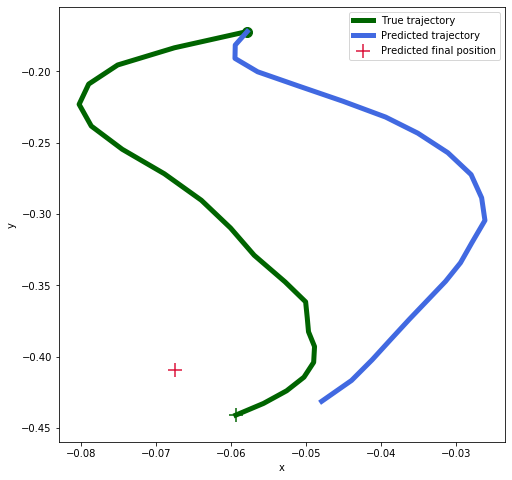

In [96]:
plot(fallen, j=3, data="eval")

In [18]:
def compute_error(folders, H=20,data="train",it=-1):
    assert data in ["train", "eval"]
    [D,C,name] = folders
    with open("data/"+data+"_"+name+".pk", 'rb') as f:
        samples = pickle.load(f)
    obs = samples['obs']
    
    Dpred = scipy.io.loadmat(D+"/logs.mat")[data+"_pred"][it][0]
    Cpred = scipy.io.loadmat(C+"/logs.mat")[data+"_pred"][it][0]

    with open(D+"/indexes.pk", 'rb') as f:
        [[train_indexes,train_inv_indexes], [eval_indexes, eval_inv_indexes]] = pickle.load(f)

    if data == "train":
        inv_indexes = train_inv_indexes 
    else:
        inv_indexes = eval_inv_indexes
    
    D_error, C_error, error0 = [], [], []
    
    mean_pos = []
    for j in tqdm(range(len(inv_indexes))):
        [i,t] = inv_indexes[j]
        true_final_pos = np.array(obs[i])[t+H, 28:31]-np.array(obs[i])[t, 28:31]
        mean_pos.append(np.copy(true_final_pos))
    mean_pos = np.mean(mean_pos, axis=0)
    for j in tqdm(range(len(inv_indexes))):
        [i,t] = inv_indexes[j]
        true_final_pos = np.array(obs[i])[t+H, 28:31]-np.array(obs[i])[t, 28:31]
        D_pred_pos = Dpred[H,j]
        C_pred_pos = Cpred[j]
        D_error.append( np.linalg.norm(true_final_pos-D_pred_pos))
        C_error.append( np.linalg.norm(true_final_pos-C_pred_pos))
        error0.append(np.linalg.norm(true_final_pos-mean_pos))
        
    plot_boxplot([D_error, C_error, error0], ['multi-step', 'one-step', 'Null'], log=True)
    plot_boxplot([1-np.array(D_error)/np.array(error0), 1-np.array(C_error)/np.array(error0)],
                 ['multi-step', 'one-step'], ylim=((-1,1)))


100%|██████████| 22006/22006 [00:00<00:00, 52140.45it/s]


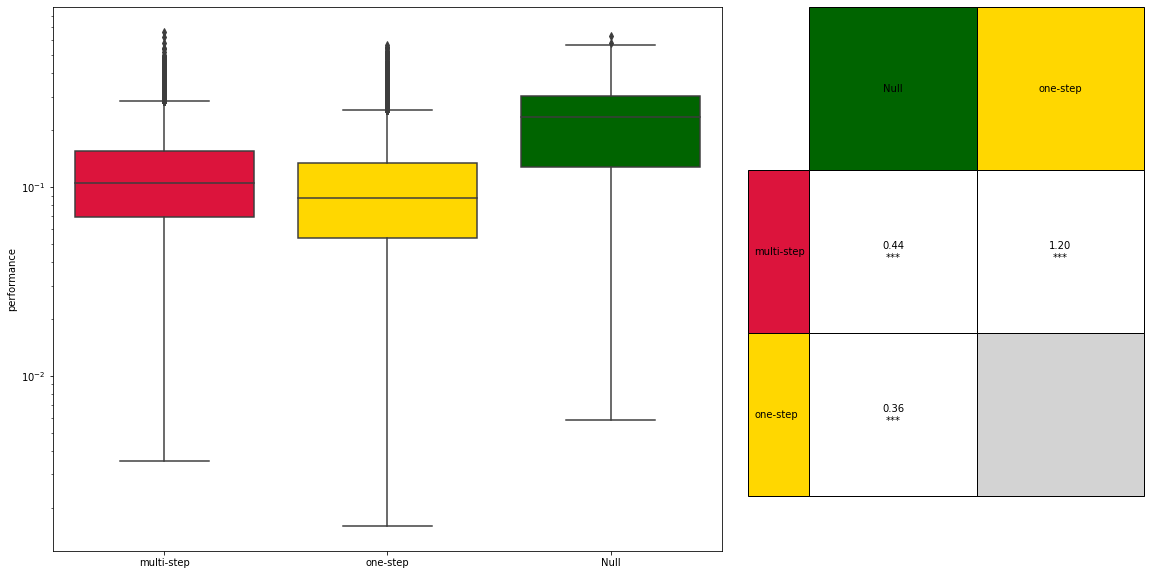

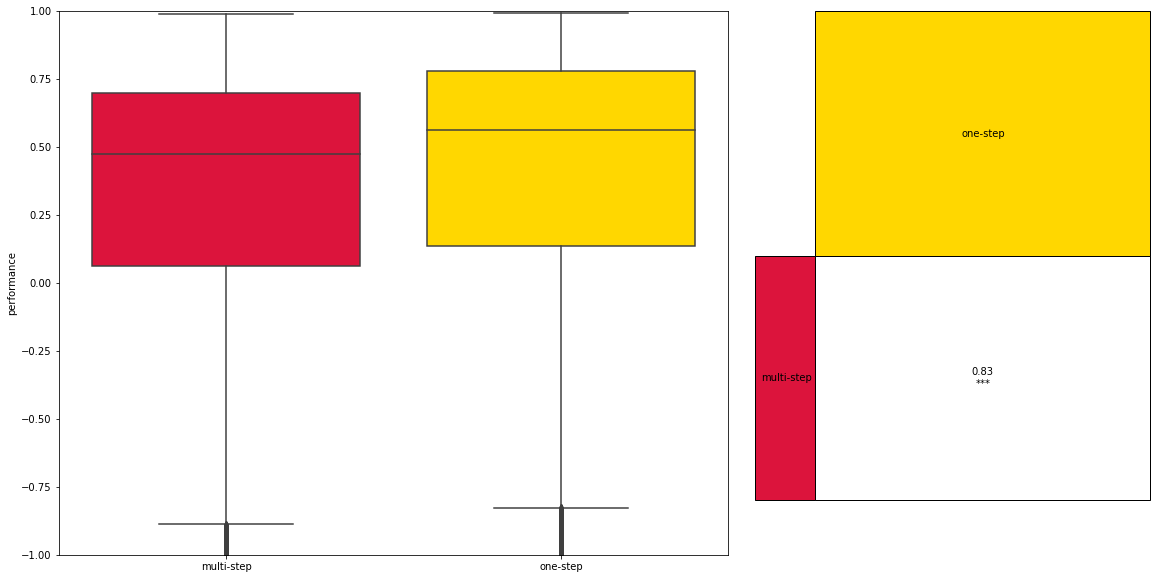

In [19]:
compute_error(fallen, data='eval', it=-1)

In [6]:
def compute_qualitative_error(folders, H=20,data="train",it=-1):
    assert data in ["train", "eval"]
    [D,C,name] = folders
    with open("data/"+data+"_"+name+".pk", 'rb') as f:
        samples = pickle.load(f)
    obs = samples['obs']
    
    Dpred = scipy.io.loadmat(D+"/logs.mat")[data+"_pred"][it][0]
    Cpred = scipy.io.loadmat(C+"/logs.mat")[data+"_pred"][it][0]

    with open(D+"/indexes.pk", 'rb') as f:
        [[train_indexes,train_inv_indexes], [eval_indexes, eval_inv_indexes]] = pickle.load(f)

    if data == "train":
        inv_indexes = train_inv_indexes 
    else:
        inv_indexes = eval_inv_indexes
    
    D_error, C_error = [[0,0],[0,0]], [[0,0],[0,0]]
    for j in tqdm(range(len(inv_indexes))):
        [i,t] = inv_indexes[j]
        true_z = np.array(obs[i])[t+H, 30]
        true_final_pos = np.array(obs[i])[t+H, 28:30]-np.array(obs[i])[t, 28:30]
        D_pos = Dpred[H,j]
        C_pos = Cpred[j]
        z0 = np.array(obs[i])[t, 30] 
        t = true_z > 0.13
        d = (D_pos[2]+z0) > 0.13
        c = (C_pos[2]+z0) > 0.13
        D_error[d][t] += 1
        C_error[c][t] += 1         
    return (np.array(D_error), np.array(C_error))

In [7]:
def analyse_CM(CM, toprint=False):
    [[TP, FP], [FN, TN]] = CM
    TPR = TP/(TP+FN) if (TP +FN) !=0 else 0
    TNR = TN/(TN+FP) if (FP +TN) !=0 else 0
    ACC = (TP+TN)/(TP+TN+FP+FN) if (TP+TN+FP+FN) !=0 else 0
    Precision = TP/(TP+FP) if (TP+FP) !=0 else 0
    FS = 2*TP/(2*TP+FP+FN) if (2*TP+FP+FN) !=0 else 0
    if toprint:
        print("TPR: ",TPR)
        print("TNR: ", TNR)
        print("ACC: ", ACC)
        print("Precision: ", Precision)
        print("FS: ",FS)
    return [TPR,TNR, ACC,Precision,FS]

In [8]:
CMD, CMC = compute_qualitative_error(fallen, data='eval', it=-1)

  0%|          | 0/22006 [00:00<?, ?it/s]/home/timothee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/timothee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
100%|██████████| 22006/22006 [00:00<00:00, 66298.08it/s]


In [10]:
print("D")
analyse_CM(CMD, True)
print("C")
print(CMC)
analyse_CM(CMC,True);

D
TPR:  0.3371636502920617
TNR:  0.9861627605292744
ACC:  0.6781786785422158
Precision:  0.95653355066558
FS:  0.4985839705465874
C
[[ 6342   761]
 [ 4101 10802]]
TPR:  0.6072967538063775
TNR:  0.9341866297673614
ACC:  0.7790602562937381
Precision:  0.8928621709136985
FS:  0.7228998062236407


In [24]:
def progression(folders, H=20,data="train",it=-1):
    assert data in ["train", "eval"]
    [D,C,name] = folders
    with open("data/"+data+"_"+name+".pk", 'rb') as f:
        samples = pickle.load(f)
    obs = samples['obs']
    
    Cpred_all = scipy.io.loadmat(C+"/logs.mat")[data+"_pred"]
    T = len(Cpred_all)
    with open(D+"/indexes.pk", 'rb') as f:
        [[train_indexes,train_inv_indexes], [eval_indexes, eval_inv_indexes]] = pickle.load(f)
    if data == "train":
        inv_indexes = train_inv_indexes 
    else:
        inv_indexes = eval_inv_indexes
        

    scores =[]
    for it in tqdm(range(T)):
        Cpred = Cpred_all[it][0]
        C_error = [[0,0],[0,0]]
        for j in range(len(inv_indexes)):
            [i,t] = inv_indexes[j]
            true_z = np.array(obs[i])[t+H, 30]
            true_final_pos = np.array(obs[i])[t+H, 28:30]-np.array(obs[i])[t, 28:30]
            C_pos = Cpred[j]
            z0 = np.array(obs[i])[t, 30] 
            t = true_z > 0.13
            c = (C_pos[2]+z0) > 0.13
            C_error[int(c)][int(t)] += 1         
        scores.append(analyse_CM(C_error))
    return np.array(scores)



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<01:21,  1.22it/s]

  2%|▏         | 2/100 [00:01<01:20,  1.22it/s]

  3%|▎         | 3/100 [00:02<01:19,  1.23it/s]

  4%|▍         | 4/100 [00:03<01:18,  1.23it/s]

  5%|▌         | 5/100 [00:04<01:17,  1.23it/s]

  6%|▌         | 6/100 [00:04<01:16,  1.23it/s]

  7%|▋         | 7/100 [00:05<01:15,  1.23it/s]

  8%|▊         | 8/100 [00:06<01:15,  1.22it/s]

  9%|▉         | 9/100 [00:07<01:14,  1.22it/s]

 10%|█         | 10/100 [00:08<01:14,  1.21it/s]

 11%|█         | 11/100 [00:09<01:14,  1.19it/s]

 12%|█▏        | 12/100 [00:09<01:14,  1.18it/s]

 13%|█▎        | 13/100 [00:10<01:14,  1.17it/s]

 14%|█▍        | 14/100 [00:11<01:13,  1.18it/s]

 15%|█▌        | 15/100 [00:12<01:11,  1.19it/s]

 16%|█▌        | 16/100 [00:13<01:10,  1.19it/s]

 17%|█▋        | 17/100 [00:14<01:11,  1.17it/s]

 18%|█▊        | 18/100 [00:15<01:09,  1.17it/s]

 19%|█▉        | 19/100 [00:15<01:08,  1.18it/s]

 20%|██        |

 45%|████▌     | 45/100 [00:08<00:10,  5.01it/s]

 46%|████▌     | 46/100 [00:08<00:10,  5.02it/s]

 47%|████▋     | 47/100 [00:09<00:10,  5.06it/s]

 48%|████▊     | 48/100 [00:09<00:10,  5.13it/s]

 49%|████▉     | 49/100 [00:09<00:09,  5.29it/s]

 50%|█████     | 50/100 [00:09<00:09,  5.44it/s]

 51%|█████     | 51/100 [00:09<00:08,  5.47it/s]

 52%|█████▏    | 52/100 [00:10<00:08,  5.44it/s]

 53%|█████▎    | 53/100 [00:10<00:08,  5.50it/s]

 54%|█████▍    | 54/100 [00:10<00:08,  5.52it/s]

 55%|█████▌    | 55/100 [00:10<00:08,  5.54it/s]

 56%|█████▌    | 56/100 [00:10<00:07,  5.56it/s]

 57%|█████▋    | 57/100 [00:10<00:07,  5.56it/s]

 58%|█████▊    | 58/100 [00:11<00:07,  5.61it/s]

 59%|█████▉    | 59/100 [00:11<00:07,  5.62it/s]

 60%|██████    | 60/100 [00:11<00:07,  5.60it/s]

 61%|██████    | 61/100 [00:11<00:06,  5.65it/s]

 62%|██████▏   | 62/100 [00:11<00:06,  5.65it/s]

 63%|██████▎   | 63/100 [00:12<00:06,  5.63it/s]

 64%|██████▍   | 64/100 [00:12<00:06,  5.58it/s]



(0, 1)

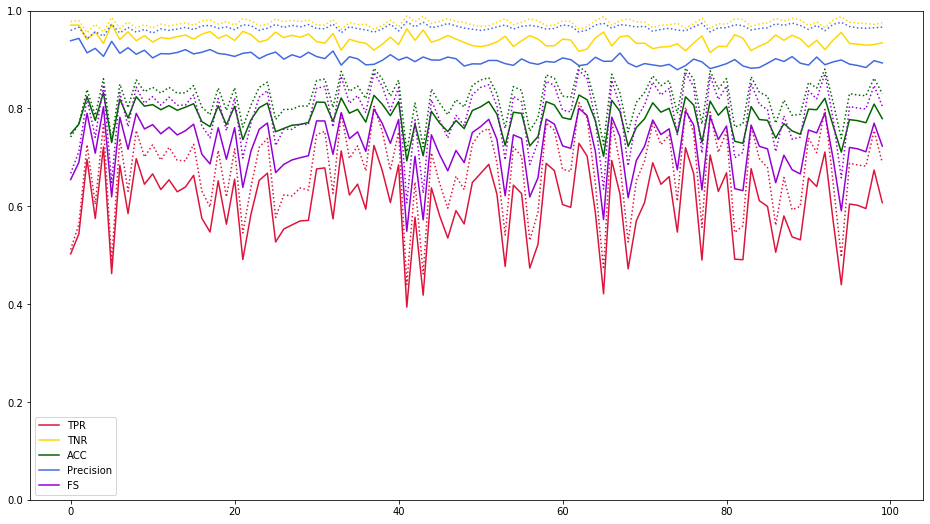

In [25]:
train_scores = progression(fallen, data="train")
scores = progression(fallen, data="eval")

labels = ['TPR','TNR', 'ACC','Precision','FS']

plt.subplots(figsize=(16,9))
for i in range(len(labels)):
    plt.plot(train_scores[:,i], ls=":", c=colors[i])
    plt.plot(scores[:,i], label=labels[i], ls="-", c=colors[i])
plt.legend()
plt.ylim((0,1))

In [62]:
 def make_data():
    with open('data/controller_72k.pk', 'rb') as f:
        samples = pickle.load(f)

    obs = samples['obs']
    rew = samples['rewards']

    fallen, notfallen = [], []
    for i in range(len(obs)):
        if rew[i][4] == -1:
            fallen.append(i)
        else:
            notfallen.append(i)

    train_f = fallen[:50000]
    eval_f = fallen[50000:]

    train_nf = notfallen[:10000]
    eval_nf = notfallen[10000:]

    train_nfbf = fallen[:40000]
    eval_nfbf = fallen[50000:]

    train_samples = {'acs': [], 'obs': [], 'reward': [], "controller": [], 'rewards':[], 't0': []}

    for i in eval_f:
        if len(samples['acs'][i]) >= 20:
            train_samples['acs'].append(samples['acs'][i][-20:])
            train_samples['obs'].append(samples['obs'][i][-21:])
            train_samples['controller'].append(samples['controller'][i])
            train_samples['rewards'].append(samples['rewards'][i])
            train_samples['reward'].append(samples['reward'][i][-20:])
            train_samples['t0'].append(len(samples['obs'][i])-21)

    for i in eval_nf:
        if len(samples['acs'][i]) >= 20:
            train_samples['acs'].append(samples['acs'][i][-20:])
            train_samples['obs'].append(samples['obs'][i][-21:])
            train_samples['controller'].append(samples['controller'][i])
            train_samples['rewards'].append(samples['rewards'][i])
            train_samples['reward'].append(samples['reward'][i][-20:])
            train_samples['t0'].append(len(samples['obs'][i])-21)

    for i in eval_nfbf:
        n = len(samples['obs'][i])
        if n/2+20<n:
            n=int(n/2)
        else:
            n=0
        if n+20 < len(samples['obs'][i]):
            train_samples['acs'].append(samples['acs'][i][n:(n+20)])
            train_samples['obs'].append(samples['obs'][i][n:(n+21)])
            train_samples['controller'].append(samples['controller'][i])
            train_samples['rewards'].append(samples['rewards'][i])
            train_samples['reward'].append(samples['reward'][i][n:(n+20)])
            train_samples['t0'].append(n)

    with open('eval_fallen.pk', 'wb') as f:
        pickle.dump(train_samples,f )

In [103]:
path = "exp/log/Saved/DC/"
file = "/logs.mat"

MPC = path + "2019-11-08--10:36:1013499" + file
Random = path + "2019-11-08--10:46:3961030" + file
MPC_survival = path + "2019-11-08--10:58:3060247" + file
MPC_75 = path + "2019-11-08--16:16:4980192"+ file
MPC_90 = path + "2019-11-08--16:27:5243549" + file
MPC_wanttofall = path + "2019-11-08--16:39:3939446" + file
saved_cost = path + "2019-11-08--11:42:2662824" + file

subdirs = [ Random,MPC_survival, MPC_75, MPC_90, MPC_wanttofall]
label =['random', 'MPC xz', 'MPC 75%', 'MPC 90%', 'fall']

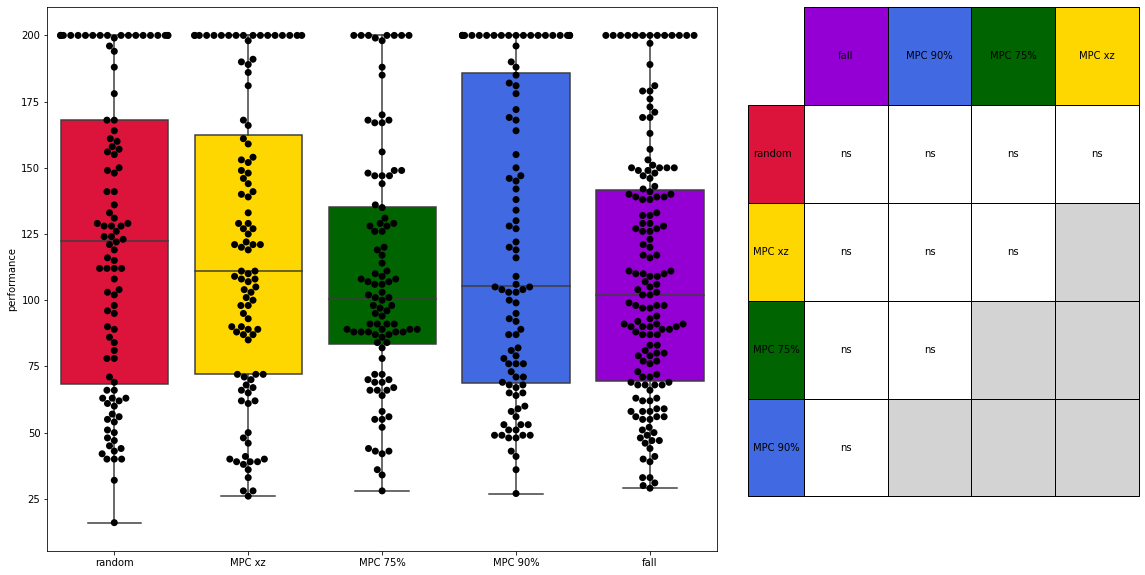

In [138]:
i = 0
times = []
for file in subdirs:
    data = scipy.io.loadmat(file)
    time = []
    for rew in data['rewards'][0]:
        time.append(len(rew[0]))
    times.append(time)
    i +=1 
plot_boxplot(times, label)

In [93]:
data = scipy.io.loadmat(MPC_90)

count = [[],[]]

for i in range(40):
    rew = data['rewards'][0][i]
    time = len(rew[0])
    t = (time == 200)
    count[t].append(np.sum(data['predicted_cost'][0][i][0]>0.5))


In [94]:
np.mean(count[0]), np.mean(count[1])

(17.6875, 3.625)

In [135]:
data = scipy.io.loadmat(MPC_90)
index = []
for i in range(100):
    rew = data['rewards'][0][i]
    time = len(rew[0])
    t = (time == 200)
    if not t:
        index.append(i)

M = np.zeros((len(index),200))
N = np.zeros((100-len(index),200))
m = 0
n = 0
for i in range(100):
    rew = data['rewards'][0][i]
    time = len(rew[0])
    t = (time == 200)
    pred = np.flip(data['predicted_cost'][0][i][0])
    if t:
        for j in range(len(pred)):
            N[n][j] = pred[j] > 5
        n+=1
    else:
        for j in range(len(pred)):
            M[m][j] = (pred[j] > 5)
        m+=1


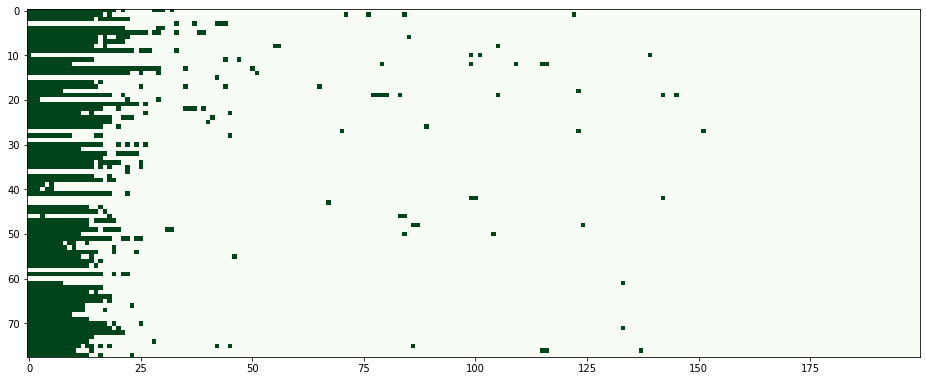

In [136]:
plt.subplots(figsize=(16,9))
plt.imshow(M,cmap='Greens',interpolation='nearest')

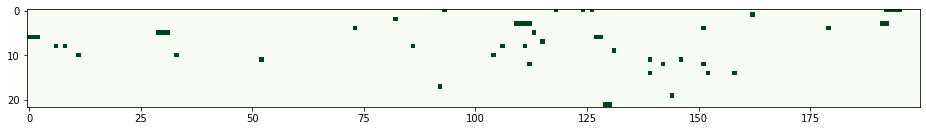

In [137]:
plt.subplots(figsize=(16,9))
plt.imshow(N,cmap='Greens',interpolation='nearest')